# Comparison of classifier vs. getSuspects

In [1]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm
import tikzplotlib as tpl
from datetime import datetime
from IPython.display import display, HTML
import glob
from zedstat import zedstat

from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from quasinet.qnet import load_qnet
from quasinet.qsampling import qsample

In [2]:
from quasinet.qsampling import qsample
from scipy.stats import entropy
import random
from quasinet.utils import sample_from_dict
from quasinet.qnet import save_qnet
from pathlib import Path


def _get_qnet(df):
    from quasinet import qnet

    qn = qnet.Qnet(
        feature_names=df.columns.values,
        min_samples_split=2,
        alpha=0.05,
        max_depth=-1,
        max_feats=-1,
        early_stopping=False,
        verbose=0,
        random_state=None,
        n_jobs=-1,
    )

    qn.fit(df.to_numpy(dtype="<U21"))

    return qn


def _get_tnets(
    df,
    df_pos=None,
    df_neg=None,
    diss_file=None,
    suspects=None,
    alpha=0.01,
):
    if df_pos is not None and df_neg is not None:
        non_null_cols = (
            (df.isna().sum() < len(df))
            & (df_pos.isna().sum() < len(df_pos))
            & (df_neg.isna().sum() < len(df_neg))
        )

        df_fmtd = df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        df_pos_fmtd = (
            df_pos.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        )
        df_neg_fmtd = (
            df_neg.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        )
        df_fmtd.to_csv("df_tmp.csv", index=False)
        df_pos_fmtd.to_csv("df_pos_tmp.csv", index=False)
        df_neg_fmtd.to_csv("df_neg_tmp.csv", index=False)

        if suspects is not None:
            Tr = truthnet()

            Tr_pos = truthnet()
            features, samples = Tr.load_data(datapath="df_tmp.csv")
            features_pos, samples_pos = Tr_pos.load_data(datapath="df_pos_tmp.csv")
            Tr.fit(modelpath="tmp_Qnet.joblib")
            Tr_pos.fit(modelpath="tmp_Qnet_pos.joblib")
            if diss_file is not None:
                Tr.dissonance = pd.read_csv(diss_file)
            else:
                Tr.getDissonance(outfile="data/tmp_dissonance_matrix.csv")
                Tr_pos.getDissonance(outfile="data/tmp_dissonance_matrix_pos.csv")
            for alpha in [0.01, 0.05, 0.1]:
                Tr.getSuspects(alpha=alpha).to_csv(f"{suspects}_full_model_{alpha}.csv")
                Tr_pos.getSuspects(alpha=alpha).to_csv(
                    f"{suspects}_pos_model_{alpha}.csv"
                )

        Tr = _get_qnet(df_fmtd)
        Tr_pos = _get_qnet(df_pos_fmtd)
        Tr_neg = _get_qnet(df_neg_fmtd)
    else:  # core mode
        Tr = truthnet()
        length = sum(df.isna().sum() < len(df))
        df.fillna(-9).astype(int).replace(-9, "").to_csv("tmpfile.csv", index=False)
        features, samples = Tr.load_data(datapath="tmpfile.csv")
        Tr.fit(modelpath="tmp_Qnet.joblib")
        if diss_file is not None:
            Tr.dissonance = pd.read_csv(diss_file)
        else:
            Tr.getDissonance(outfile="data/tmp_dissonance_matrix.csv")
        if suspects is not None:
            for alpha in [0.01, 0.05, 0.1]:
                Tr.getSuspects(alpha=alpha).to_csv(f"{suspects}_{alpha}.csv")
        coresamples = Tr.getCoresamples(alpha=alpha, steps=length)
        df_pos = df.loc[coresamples.index.values]
        if len(coresamples) == len(df):
            df_neg = None
            non_null_cols = (df.isna().sum() < len(df)) & (
                df_pos.isna().sum() < len(df_pos)
            )
            Tr_neg = None
            Tr = _get_qnet(
                df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
            )
            Tr_pos = Tr

        else:
            df_neg = df.loc[~df.index.isin(coresamples.index.values)]

            non_null_cols = (
                (df.isna().sum() < len(df))
                & (df_pos.isna().sum() < len(df_pos))
                & (df_neg.isna().sum() < len(df_neg))
            )

            Tr = _get_qnet(
                df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
            )
            Tr_pos = _get_qnet(
                df_pos.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
            )
            Tr_neg = _get_qnet(
                df_neg.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
            )

    return {
        "all": Tr,
        "pos": Tr_pos,
        "neg": Tr_neg,
        "data": df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, ""),
        # "core": coresamples,
    }


def _diss_linear(s, qnet, missing_value=0):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(1 - Ds[i][s[i]] / np.max(list(Ds[i].values())))
            elif s[i] == "missing":
                diss.append(missing_value)
            else:
                diss.append(1)

    return np.array(diss)


def _diss_log(s, qnet, missing_value=0):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(-np.log(Ds[i][s[i]]))
            elif s[i] == "missing":
                diss.append(missing_value)
            else:
                diss.append(np.inf)
        # else:
        # diss.append(missing_value)

    return np.array(diss)


def _actual_sample_dissonance(
    data_sample, diss_models, diss_fcn, order, length, missing_value=0
):
    if order is None:
        order = range(length)

    sample = np.full(length, "", dtype="<U21")

    diss = [list() for model in diss_models]

    # print(data_sample)

    for i in order:
        if data_sample[i] == "":
            sample[i] = "missing"
        else:
            sample[i] = data_sample[i]
        # [print(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]
        for d, model in zip(diss, diss_models):
            d.append(diss_fcn(sample, model, missing_value))
        # [d.append(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]

    return sample, diss


def _all_actual_samples_dissonance(
    data_samples, diss_models, diss_fcn, order, length, missing_value=0
):
    samples = list()
    dissonances = list()

    for data_sample in tqdm(data_samples):
        samp, diss = _actual_sample_dissonance(
            data_sample, diss_models, diss_fcn, order, length, missing_value
        )
        # print(len(diss), len(diss[0]), len(diss[0][8]), diss[0][8])
        # print(len(diss), len(diss[0]), len(diss[0][4]), diss[0][4])
        samples.append(samp)
        dissonances.append(diss)

    return samples, dissonances


def _sample_with_dissonance(
    sample_model,
    length,
    diss_models,
    diss_fcn=_diss_linear,
    order=None,
    data_samples=None,
    method=None,
):
    if order is None:
        order = range(length)

    if data_samples is not None:
        data_samples_df = pd.DataFrame(data_samples)
        data_sample_values = pd.Series(
            {
                col: [x for x in data_samples_df[col].unique() if x != ""]
                for col in data_samples_df
            }
        )

    sample = np.full(length, "")

    diss = [list() for model in diss_models]

    for i in order:
        if sample_model is not None:
            if method == "unconditional":
                prob_dict = sample_model.predict_distribution(np.full(length, ""), i)
                sample[i] = sample_from_dict(prob_dict)
            else:
                prob_dict = sample_model.predict_distribution(sample, i)
                sample[i] = sample_from_dict(prob_dict)
        else:
            sample[i] = random.choice(data_sample_values[i])
        [d.append(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]

    return sample, diss


def _nsamples_with_dissonance(
    n_samples,
    sample_model,
    length,
    diss_models,
    diss_fcn=_diss_linear,
    order=None,
    data_samples=None,
    method=None,
):
    samples = list()
    dissonances = list()

    for i in tqdm(range(n_samples)):
        samp, diss = _sample_with_dissonance(
            sample_model,
            length,
            diss_models,
            diss_fcn,
            order,
            data_samples,
            method,
        )
        samples.append(samp)
        dissonances.append(diss)

    return samples, dissonances


def _dissonance_data_at_question(dissonances, questions_asked):
    return np.array(
        [np.hstack([d[questions_asked - 1] for d in diss]) for diss in dissonances]
    )


# generate samples under the given models and compute dissonances under specified diss_models
def _sampling_scenario(
    n_qsamples,
    qsample_model,
    n_m2_samples,
    m2_model,
    diss_models,
    length,
    m2_method=None,
    n_runif_samples=None,
    diss_fcn=_diss_linear,
    order=None,
    data_samples=None,
    missing_value=0,
):
    samples = {}
    dissonances = {}

    if data_samples is not None:
        samples["actual"], dissonances["actual"] = _all_actual_samples_dissonance(
            data_samples.to_numpy(), diss_models, diss_fcn, order, length, missing_value
        )

    samples["qsampled"], dissonances["qsampled"] = _nsamples_with_dissonance(
        n_qsamples, qsample_model, length, diss_models, diss_fcn, order
    )

    samples["m2"], dissonances["m2"] = _nsamples_with_dissonance(
        n_m2_samples,
        m2_model,
        length,
        diss_models,
        diss_fcn,
        order,
        method=m2_method,
    )

    if n_runif_samples is not None:
        samples["runif"], dissonances["runif"] = _nsamples_with_dissonance(
            n_runif_samples,
            None,
            length,
            diss_models,
            diss_fcn,
            order,
            data_samples,
        )

    return samples, dissonances


def _diss_dataset(dissonances, questions_asked, groups=["qsampled", "m2"]):
    diss_dataset = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(dissonances[group], questions_asked)
            ).assign(y=group)
            for group in groups
        ]
    )
    return diss_dataset


def _save_sampling_scenarios(
    iter,
    name,
    df,
    n_qsamples,
    n_m2_samples,
    df_pos=None,
    df_neg=None,
    diss_file=None,
    diss_fcn=_diss_linear,
    order=None,
    n_runif_samples=None,
    invert_pos=False,
    missing_value=0,
    m2_method=None,
):
    Path(f"{name}").mkdir(parents=True, exist_ok=True)
    for i in tqdm(iter):
        tn = _get_tnets(
            df=df,
            df_pos=df_pos,
            df_neg=df_neg,
            diss_file=diss_file,
            suspects=f"{name}/{order}_order_suspects_{i}_",
        )

        if diss_file is None:
            pd.read_csv("data/tmp_dissonance_matrix.csv").to_csv(
                f"{name}/{order}_order_dissonance_matrix_{i}.csv"
            )

        data_samples = tn["data"]
        full_model = tn["all"]
        if invert_pos is True:
            pos_model = tn["neg"]
            neg_model = tn["pos"]
        else:
            pos_model = tn["pos"]
            neg_model = tn["neg"]

        length = len(full_model.feature_names)

        if order == "entropy":
            order_type = "entropy"
            print("wwwwww")
            Ds = full_model.predict_distributions(np.full(length, ""))
            entrpy = list()
            for i in range(len(Ds)):
                entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))
            order = pd.Series(entrpy).sort_values().index

        if order == "random":
            order_type = "random"
            order = list(range(length))
            random.shuffle(order)
            order = pd.Series(order)

        order.to_csv(f"{name}/{order_type}_order_{i}.csv")

        diss_models = list()
        for model, model_name in zip(
            [full_model, neg_model, pos_model], ["full_model", "neg_model", "pos_model"]
        ):
            if model is not None:
                diss_models.append(model)
                save_qnet(
                    model,
                    f"{name}/{order_type}_order_{model_name}_{i}.joblib",
                    low_mem=True,
                    gz=True,
                )

        s, d = _sampling_scenario(
            n_qsamples,
            full_model,
            n_m2_samples,
            pos_model,
            diss_models,
            length,
            m2_method,
            n_runif_samples,
            diss_fcn,
            order,
            data_samples=data_samples,
            missing_value=missing_value,
        )

        pd.to_pickle(s, f"{name}/{order_type}_order_samples_{i}.pkl")
        pd.to_pickle(d, f"{name}/{order_type}_order_disson_{i}.pkl")
        order = order_type

In [3]:
def _dissonance_data_at_question(dissonances, questions_asked):
    return np.array(
        [np.hstack([d[questions_asked - 1] for d in diss]) for diss in dissonances]
    )


def _diss_dataset(dissonances, questions_asked, groups=["qsampled", "m2"]):
    diss_dataset = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(dissonances[group], questions_asked)
            ).assign(y=group)
            for group in groups
        ]
    )
    return diss_dataset


def _maling_prob(d, groups, questions_asked, data_index):
    data = _diss_dataset(d, questions_asked, groups=groups)
    X_train, X_test, y_train, y_test = train_test_split(
        data.drop("y", axis="columns"), data["y"], test_size=0.33
    )

    fig, ax = plt.subplots()

    classifier = RandomForestClassifier(n_jobs=-1)

    classifier.fit(
        X_train.to_numpy(),
        y_train.replace(
            {
                groups[0]: 0,
                groups[1]: 1,
            }
        ),
    )

    r = RocCurveDisplay.from_estimator(
        classifier,
        X_test.to_numpy(),
        y_test.replace(
            {
                groups[0]: 0,
                groups[1]: 1,
            }
        ),
        pos_label=1,
        ax=ax,
        name=questions_asked,
    )

    plt.close()

    actual_data = _diss_dataset(d, questions_asked, groups=["actual"])

    pred = pd.Series(
        classifier.predict(actual_data.drop(["y"], axis="columns"))
    ).replace({0: "baseline", 1: groups[1]})

    pred_prob = pd.Series(
        classifier.predict_proba(actual_data.drop(["y"], axis="columns"))[:, 1],
        name=f"prob_{groups[1]}",
    )

    m2_prob = (
        pd.concat([actual_data.drop(["y"], axis="columns"), pred_prob], axis="columns")
        .set_index(data_index)
        .reset_index()
        # .sort_values(by="prob_m2", ascending=False)
    )

    return m2_prob

In [4]:
def _resample_null(nsamples, qsteps, num_questions, basepath, dffg, dffgm, dd):
    num_models = len(glob.glob(f"{basepath}random_order_disson*.pkl"))

    sample_models = [
        load_qnet(
            f"{basepath}random_order_full_model_{i}.joblib.gz",
            gz=True,
        )
        for i in range(num_models)
    ]

    diss_models = [[
        load_qnet(
            f"{basepath}random_order_{model}_{i}.joblib.gz",
            gz=True,
        ) for model in ["full_model", "neg_model", "pos_model"]]
        for i in range(num_models)
    ]

    orders = [
        pd.read_csv(f"{basepath}random_order_{i}.csv", index_col=0)["0"]
        for i in range(num_models)
    ]

    dffg_list = list()
    dffgm_list = list()
    dd_list = list()
    resamp_diss_list = list()

    for sample_model, diss_model, order in tqdm(zip(sample_models, diss_models, orders)):
        empty_string = np.full(len(sample_model.feature_names), "", dtype="<U21")

        resampled = np.array(
            [qsample(empty_string, sample_model, qsteps) for _ in tqdm(range(nsamples))]
        )

        resampled_diss = _all_actual_samples_dissonance(
            resampled, diss_model, _diss_linear, order, len(sample_model.feature_names)
        )

        resampled, resamp_diss = _all_actual_samples_dissonance(
            resampled, diss_model, _diss_linear, order, len(sample_model.feature_names), 0
        )

        resamp_diss_list.append(resamp_diss)

        rsdffg = pd.concat(
            [
                pd.DataFrame(
                    _dissonance_data_at_question(resampled_diss[1], questions_asked)
                ).assign(y="resampled", questions=str(questions_asked))
                for questions_asked in range(1, num_questions)
            ]
        )

        rsdffgm = (
            rsdffg.melt(id_vars=["y", "questions"])
            .query("~value.isna()")
            .assign(
                questions=lambda x: x["questions"].astype(int),
                variable=lambda x: x["variable"].astype(int),
            )
        )

        rsdd = pd.concat(
            [
                rsdffg.drop(["y", "questions"], axis="columns").mean(axis=1),
                rsdffg["y"],
                rsdffg["questions"],
            ],
            axis=1,
        ).set_axis(["dissonance", "y", "questions"], axis="columns")

        dffg_list.append(rsdffg)
        dffgm_list.append(rsdffgm)
        dd_list.append(rsdd)

    new_dffg = pd.concat([dffg, pd.concat(dffg_list)])
    new_dffgm = pd.concat([dffgm, pd.concat(dffgm_list)])
    new_dd = pd.concat([dd, pd.concat(dd_list)])

    new_dffg.to_csv(f"{basepath}dffg_resampled.csv", index=False)
    new_dffgm.to_csv(f"{basepath}dffgm_resampled.csv", index=False)
    new_dd.to_csv(f"{basepath}dd_resampled.csv", index=False)

    return new_dffg, new_dffgm, new_dd, resamp_diss_list

# PTSD


## patching diss files to add resampled

In [6]:
basepath = f"disson_new/ptsd/core/disson_ptsd_qmra/"

qsteps = 100
nsamples = 10
num_questions = 212

rdffg, rdffgm, rdd, rdiss = _resample_null(
    nsamples,
    qsteps,
    num_questions,
    basepath,
    pd.read_csv(f"{basepath}dffg.csv"),
    pd.read_csv(f"{basepath}dffgm.csv"),
    pd.read_csv(f"{basepath}dd.csv"),
)

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
len(rdiss)

10

In [10]:
basepath = "disson_new/ptsd/core/disson_ptsd_qmra/"
diss = [
    pd.read_pickle(d)
    for d in glob.glob(f"{basepath}random_order_disson*.pkl")
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob(f"{basepath}random_order_samples*.pkl")
]

In [11]:
for d in diss:
    d["resampled"] = rdiss[1]

for s in samps:
    s['resampled'] = rdiss[0]

In [13]:
_diss_dataset(diss[0], 20, groups=["resampled", "m2"])

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,y
0,0.227848,0.0,0.000000,0.941176,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,resampled
1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,...,0.000000,0.388235,0.50000,0.000000,0.000000,0.000000,0.000000,0.920792,0.970297,resampled
2,0.227848,0.0,0.000000,0.000000,0.000000,0.000000,0.75,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.705882,0.392405,0.000000,0.000000,0.000000,0.000000,resampled
3,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,resampled
4,0.772727,0.0,0.000000,0.000000,0.000000,0.000000,1.00,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.52381,0.534483,0.962025,0.000000,0.555556,0.000000,0.000000,resampled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.0,0.655489,0.134146,0.750000,0.993333,0.39,0.00000,0.353230,1.000000,...,0.750000,0.865385,0.00000,0.000000,0.000000,0.094937,0.975000,0.892950,1.000000,m2
96,0.980372,1.0,0.000000,0.000000,1.000000,0.000000,0.39,0.00000,0.316226,0.933131,...,0.568182,0.000000,0.00000,0.000000,0.000000,0.094937,0.000000,0.890339,0.000000,m2
97,0.043222,0.0,0.025729,0.134146,0.000000,0.000000,0.00,0.02381,0.000000,0.545455,...,0.000000,0.865385,0.00000,0.000000,0.714286,0.000000,0.775000,0.884024,1.000000,m2
98,0.703176,0.0,0.139871,0.317073,0.977778,1.000000,0.00,0.00000,0.353230,0.000000,...,0.750000,0.000000,0.00000,1.000000,0.714286,0.995294,0.975000,0.479624,0.833333,m2


In [15]:
_diss_dataset(diss[0], 20, groups=["resampled", "m2"])['y'].unique()

array(['resampled', 'm2'], dtype=object)

## Runif case

mean runif prob:  0.7676842105263157
mean runif prob (suspects):  0.9649358974358975


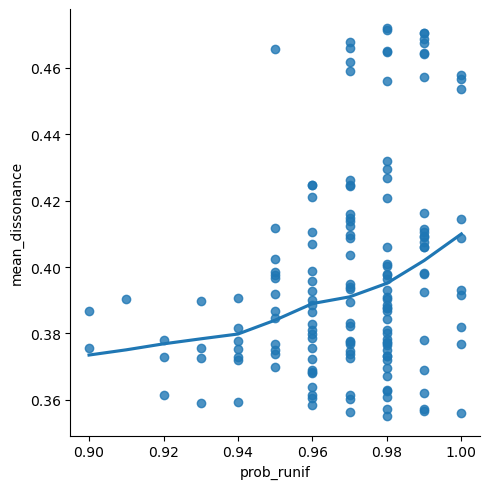

In [16]:
groups = ["resampled", "runif"]
questions_asked = 211
alpha = 0.01

mdfs = pd.concat(
    [
        _maling_prob(
            d,
            groups,
            questions_asked,
            pd.read_csv("data/ptsd/PTSD_cognet_test.csv")["record_id"],
        )
        for d in diss
    ]
)
mdfsavg = mdfs.groupby("record_id", as_index=False).mean()

suspects = pd.concat(
    [
        pd.read_csv(
            f"{basepath}random_order_suspects_{i}__{alpha}.csv",
            index_col=0,
        )
        for i in range(10)
    ]
)
suspects_mean = suspects.groupby(suspects.index).mean()

suspects_prob = mdfsavg.iloc[suspects.index, [0, -1]].join(suspects)
# display(suspects_prob)

print(f"mean {groups[1]} prob: ", mdfsavg[f"prob_{groups[1]}"].mean())
print(f"mean {groups[1]} prob (suspects): ", mdfsavg.iloc[suspects.index, -1].mean())

susp_diss = pd.concat(
    [
        _maling_prob(
            diss[i],
            groups,
            questions_asked,
            pd.read_csv("data/ptsd/PTSD_cognet_test.csv")["record_id"],
        )
        .join(
            pd.read_csv(
                f"{basepath}random_order_suspects_{i}__{alpha}.csv",
                index_col=0,
            ),
        )
        .assign(alpha=alpha)
        for i in range(len(diss))
        for alpha in [0.01]
    ]
)

sns.lmplot(susp_diss, x="prob_runif", y="mean_dissonance", lowess=True)

In [120]:
mdfs

,record_id,0,1,2,3,4,5,6,7,8,...,624,625,626,627,628,629,630,631,632,prob_runif
0,CAT1001,0.291837,0.000000,0.267569,0.219360,0.786682,0.030078,0.000000,0.404607,0.184265,...,0.846146,0.911163,0.592942,0.000000,0.955427,0.000000,0.151581,0.775791,0.000000,0.16
1,CAT1002,0.454949,0.000000,0.208358,0.000000,0.000000,0.120542,0.000000,0.000000,0.000000,...,0.840836,0.909869,0.642174,0.650388,0.953610,0.919834,0.752464,0.767269,0.474359,0.13
2,CAT1003,0.368417,0.000000,0.000000,0.218065,0.000000,0.073526,0.244334,0.000000,0.000000,...,0.000000,0.000000,0.918979,0.914824,0.880934,0.801600,0.114199,0.000000,0.475067,0.41
3,CAT1004,0.327299,0.000000,0.550416,0.171933,0.907131,0.000000,0.244819,0.000000,0.000000,...,0.000000,0.543259,0.601385,0.644261,0.914772,0.000000,0.000000,0.000000,0.000000,0.04
4,CAT1005,0.372335,0.000000,0.000000,0.000000,0.824168,0.032395,0.000000,0.306315,0.000000,...,0.000000,0.000000,0.000000,0.112861,0.000000,0.055691,0.323665,0.000000,0.106610,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,CAT1300,0.210661,0.000000,0.273225,0.163922,0.000000,0.651481,0.297269,0.539707,0.272951,...,0.020219,0.000000,0.206797,0.000000,0.769891,0.000000,0.000000,0.000000,0.000000,0.33
300,CAT1301,0.000000,0.000000,0.000000,0.166040,0.885014,0.000000,0.000000,0.787774,0.626818,...,0.978695,1.000000,0.978632,0.986985,1.000000,0.979756,0.954326,0.828560,0.439506,0.31
301,CAT1302,0.000000,0.525903,0.000000,0.348520,0.000000,0.000000,0.806371,0.792457,0.307898,...,0.679357,0.448463,0.000000,0.712890,0.000000,0.746922,0.000000,0.947244,0.531223,0.09
302,CAT1303,0.296776,0.558346,0.263407,0.000000,0.000000,0.000000,0.000000,0.000000,0.431593,...,0.691304,0.000000,0.768625,0.292217,0.925292,0.000000,0.000000,0.000000,0.000000,0.19


In [132]:
susp_diss[["record_id", "prob_runif", "mean_dissonance"]]

,record_id,prob_runif,mean_dissonance
0,CAT1001,0.24,NaN
1,CAT1002,0.12,NaN
2,CAT1003,0.30,NaN
3,CAT1004,0.04,NaN
4,CAT1005,0.14,NaN
...,...,...,...
299,CAT1300,0.24,NaN
300,CAT1301,0.45,NaN
301,CAT1302,0.06,NaN
302,CAT1303,0.08,NaN


In [135]:
dfns.index.isin(suspects.index)

array([False, False, False, ..., False, False, False])

In [134]:
dfns

,record_id,prob_runif,mean_dissonance
0,CAT1001,0.16,0.292575
1,CAT1002,0.13,0.263253
2,CAT1003,0.41,0.320114
3,CAT1004,0.04,0.266483
4,CAT1005,0.09,0.289491
...,...,...,...
299,CAT1300,0.33,0.245569
300,CAT1301,0.31,0.404944
301,CAT1302,0.09,0.268153
302,CAT1303,0.19,0.278968


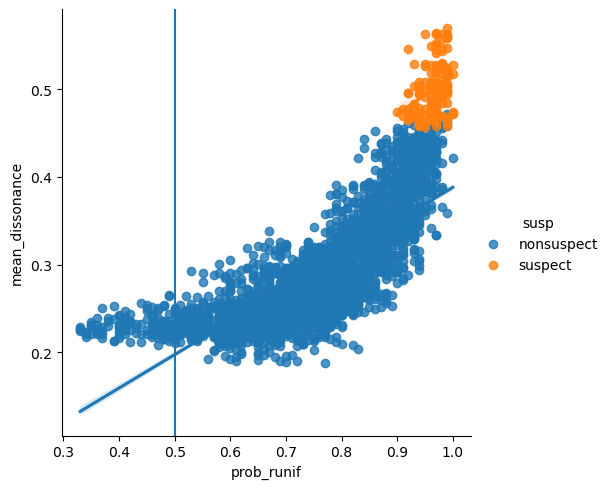

In [17]:
nonsuspects = mdfsavg[~mdfsavg.index.isin(suspects.index)]["record_id"]
mdfns = mdfs.query("record_id.isin(@nonsuspects)")

dfns = pd.concat(
    [
        mdfns.iloc[:, np.r_[0, -1]],
        mdfns.iloc[:, 1:-1].mean(axis=1).rename("mean_dissonance"),
    ],
    axis=1,
)

dfns = pd.concat(
    [
        mdfs.iloc[:, np.r_[0, -1]],
        mdfs.iloc[:, 1:-1].mean(axis=1).rename("mean_dissonance"),
    ],
    axis=1,
)

dfns["susp"] = np.where(dfns.index.isin(suspects.index), "suspect", "nonsuspect")

sns.lmplot(dfns, x="prob_runif", y="mean_dissonance", hue="susp", lowess=False)

plt.axvline(x=0.5)

In [147]:
dfns.to_csv("ptsd_random_classif_prob_diss.csv", index=False)

In [125]:
mdfs.query("record_id.isin(@nonsuspects)").iloc[:, 1:-1].mean(axis=1)

0      0.292575
1      0.263253
2      0.320114
3      0.266483
4      0.289491
         ...   
299    0.245569
300    0.404944
301    0.268153
302    0.278968
303    0.273042
Length: 2870, dtype: float64

In [116]:
suspects.index

Index([  9,  60,  63,  86,  98, 159, 188, 210, 221, 222,
       ...
       159, 188, 210, 221, 222, 225, 252, 261, 282, 291],
      dtype='int64', length=152)

In [108]:
mdfsavg.iloc[:, 1:-1]

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.000000,0.079365,0.000000,0.000000,0.000000,0.099548,0.088889,0.000000,0.063181,0.000000,...,0.078042,0.063307,0.060091,0.094582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.224597,0.079128,0.111111,0.167756,0.210877,0.089114,0.187881,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.048663,0.087575,0.004971,0.001068,0.078935,0.207995,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.386756,0.155243,0.055556,0.000000,0.060606,0.032349,...,0.047619,0.027778,0.098212,0.000000,0.106316,0.074854,0.000000,0.020833,0.085394,0.287615
3,0.000000,0.057174,0.000000,0.077825,0.059524,0.035928,0.057057,0.000000,0.000000,0.037037,...,0.097415,0.061111,0.101852,0.094582,0.087575,0.226901,0.000000,0.091049,0.172069,0.000000
4,0.000000,0.037037,0.005626,0.000000,0.005626,0.097479,0.000000,0.000000,0.000000,0.000000,...,0.016667,0.000000,0.135908,0.109266,0.137528,0.014493,0.000000,0.166481,0.233128,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048787,...,0.078412,0.000000,0.018913,0.106481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1232,0.135709,0.073714,0.000000,0.000000,0.203175,0.000000,0.000000,0.012346,0.074074,0.032349,...,0.000000,0.005168,0.013605,0.000000,0.000000,0.004971,0.000000,0.083148,0.149795,0.000000
1233,0.065880,0.199930,0.271508,0.102917,0.000000,0.073563,0.037037,0.000000,0.000000,0.034632,...,0.000000,0.111111,0.086022,0.017094,0.143151,0.054971,0.000000,0.072879,0.145096,0.000000
1234,0.000000,0.103098,0.000000,0.070707,0.012121,0.000000,0.000000,0.000000,0.012121,0.000000,...,0.000000,0.000000,0.094974,0.000000,0.012640,0.004971,0.000000,0.000000,0.000000,0.000000


In [56]:
susp_diss

,record_id,0,1,2,3,4,5,6,7,8,...,626,627,628,629,630,631,632,prob_runif,mean_dissonance,alpha
0,CAT1001,0.291837,0.000000,0.267569,0.219360,0.786682,0.030078,0.000000,0.404607,0.184265,...,0.592942,0.000000,0.955427,0.000000,0.151581,0.775791,0.000000,0.14,NaN,0.01
1,CAT1002,0.454949,0.000000,0.208358,0.000000,0.000000,0.120542,0.000000,0.000000,0.000000,...,0.642174,0.650388,0.953610,0.919834,0.752464,0.767269,0.474359,0.07,NaN,0.01
2,CAT1003,0.368417,0.000000,0.000000,0.218065,0.000000,0.073526,0.244334,0.000000,0.000000,...,0.918979,0.914824,0.880934,0.801600,0.114199,0.000000,0.475067,0.43,NaN,0.01
3,CAT1004,0.327299,0.000000,0.550416,0.171933,0.907131,0.000000,0.244819,0.000000,0.000000,...,0.601385,0.644261,0.914772,0.000000,0.000000,0.000000,0.000000,0.04,NaN,0.01
4,CAT1005,0.372335,0.000000,0.000000,0.000000,0.824168,0.032395,0.000000,0.306315,0.000000,...,0.000000,0.112861,0.000000,0.055691,0.323665,0.000000,0.106610,0.08,NaN,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,CAT1300,0.210661,0.000000,0.273225,0.163922,0.000000,0.651481,0.297269,0.539707,0.272951,...,0.206797,0.000000,0.769891,0.000000,0.000000,0.000000,0.000000,0.19,NaN,0.01
300,CAT1301,0.000000,0.000000,0.000000,0.166040,0.885014,0.000000,0.000000,0.787774,0.626818,...,0.978632,0.986985,1.000000,0.979756,0.954326,0.828560,0.439506,0.32,NaN,0.01
301,CAT1302,0.000000,0.525903,0.000000,0.348520,0.000000,0.000000,0.806371,0.792457,0.307898,...,0.000000,0.712890,0.000000,0.746922,0.000000,0.947244,0.531223,0.08,NaN,0.01
302,CAT1303,0.296776,0.558346,0.263407,0.000000,0.000000,0.000000,0.000000,0.000000,0.431593,...,0.768625,0.292217,0.925292,0.000000,0.000000,0.000000,0.000000,0.19,NaN,0.01


In [58]:
susp_diss.query("mean_dissonance.notna()").to_csv(
    "suspects_mean_diss_runif_prob.csv", index=False
)

In [103]:
pd.read_csv("suspects_mean_diss_runif_prob.csv")

,record_id,0,1,2,3,4,5,6,7,8,...,626,627,628,629,630,631,632,prob_runif,mean_dissonance,alpha
0,CAT1010,0.253044,0.417490,0.192165,0.307181,0.854707,0.585333,0.228021,0.718373,0.025126,...,0.892031,0.978703,0.941106,0.980451,0.984558,0.940407,0.444563,0.58,0.380361,0.01
1,CAT1061,0.000000,0.936884,0.188545,0.199626,0.887528,0.673175,0.819055,0.700147,0.476371,...,0.987577,0.613485,0.919558,0.978455,0.984516,0.930622,0.444068,0.54,0.429343,0.01
2,CAT1064,0.000000,0.849270,0.263930,0.000000,0.000000,0.595251,0.818115,0.722459,0.000000,...,0.987592,0.978564,0.995565,0.980154,0.980835,0.930635,0.444068,0.73,0.401782,0.01
3,CAT1087,0.000000,0.000000,0.273668,0.000000,0.853183,0.595364,0.235537,0.684386,0.468832,...,0.594997,0.982454,0.981164,0.978683,0.980421,0.930622,0.444415,0.62,0.377962,0.01
4,CAT1099,0.439223,0.000000,0.000000,0.000000,0.000000,0.000000,0.545466,0.186764,0.468832,...,0.892355,0.912877,0.965859,0.984068,0.980732,0.940969,0.268641,0.90,0.414350,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,CAT1226,0.000000,0.000000,0.606805,0.167394,0.000000,0.637458,0.097234,0.728634,0.025092,...,0.978176,0.991348,0.984577,0.865217,0.948987,0.945529,0.449503,0.27,0.359670,0.01
148,CAT1253,0.130507,0.874552,0.256546,0.167266,0.777068,0.637458,0.443384,0.136339,0.707110,...,0.867852,0.982878,0.896263,0.977565,0.949757,0.827031,0.444627,0.68,0.388622,0.01
149,CAT1262,0.000000,0.000000,0.000000,0.000000,0.000000,0.682348,0.777477,0.811917,0.563182,...,0.978220,0.983475,1.000000,0.976471,0.981180,0.838411,0.444339,0.59,0.464279,0.01
150,CAT1283,0.109569,0.277486,0.000000,0.000000,0.000000,0.637125,0.776613,0.727118,0.457222,...,0.978371,0.983043,1.000000,0.878977,0.949807,0.946420,0.436033,0.83,0.469505,0.01


In [104]:
pd.read_csv("suspects_mean_diss_runif_prob.csv")[
    ["record_id", "prob_runif", "mean_dissonance", "alpha"]
].to_csv("suspects_mean_diss_runif_prob_0.01.csv", index=False)

## Expert malingering case

In [18]:
groups = ["resampled", "m2"]
questions_asked = 211
alpha = 0.01

mdfs = pd.concat(
    [
        _maling_prob(
            d,
            groups,
            questions_asked,
            pd.read_csv("data/ptsd/PTSD_cognet_test.csv")["record_id"],
        )
        for d in diss
    ]
)
mdfsavg = mdfs.groupby("record_id", as_index=False).mean()

suspects = pd.concat(
    [
        pd.read_csv(
            f"disson_ptsd/core/disson_ptsd_core_with_actual_random_order_suspects_{i}__{alpha}.csv",
            index_col=0,
        )
        for i in range(10)
    ]
)
suspects_mean = suspects.groupby(suspects.index).mean()

suspects_prob = mdfsavg.iloc[suspects.index, [0, -1]].join(suspects)
# display(suspects_prob)

print(f"mean {groups[1]} prob: ", mdfsavg[f"prob_{groups[1]}"].mean())
print(f"mean {groups[1]} prob (suspects): ", mdfsavg.iloc[suspects.index, -1].mean())

susp_diss = pd.concat(
    [
        _maling_prob(
            diss[i],
            groups,
            questions_asked,
            pd.read_csv("data/ptsd/PTSD_cognet_test.csv")["record_id"],
        )
        .join(
            pd.read_csv(
                f"disson_ptsd/core/disson_ptsd_core_with_actual_random_order_suspects_{i}__{alpha}.csv",
                index_col=0,
            )
        )
        .assign(alpha=alpha)
        for i in range(len(diss))
        for alpha in [0.01]
    ]
)

mean m2 prob:  0.8162796052631579
mean m2 prob (suspects):  0.6366118421052631


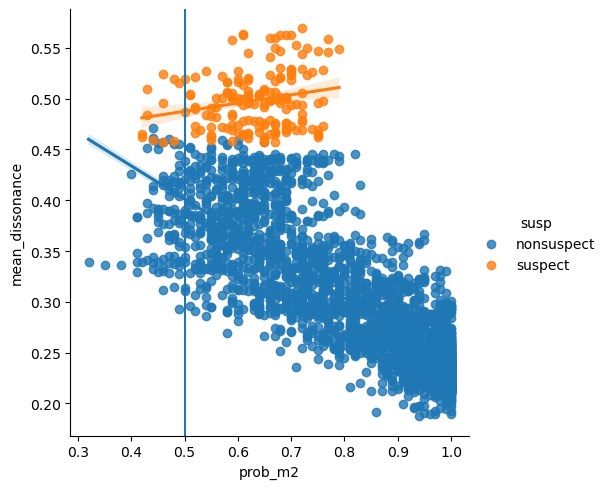

In [19]:
nonsuspects = mdfsavg[~mdfsavg.index.isin(suspects.index)]["record_id"]
mdfns = mdfs.query("record_id.isin(@nonsuspects)")

dfns = pd.concat(
    [
        mdfns.iloc[:, np.r_[0, -1]],
        mdfns.iloc[:, 1:-1].mean(axis=1).rename("mean_dissonance"),
    ],
    axis=1,
)

dfns = pd.concat(
    [
        mdfs.iloc[:, np.r_[0, -1]],
        mdfs.iloc[:, 1:-1].mean(axis=1).rename("mean_dissonance"),
    ],
    axis=1,
)

dfns["susp"] = np.where(dfns.index.isin(suspects.index), "suspect", "nonsuspect")

sns.lmplot(dfns, x="prob_m2", y="mean_dissonance", hue="susp", lowess=False)

plt.axvline(x=0.5)

In [144]:
dfns.to_csv("ptsd_m2_classif_prob_diss.csv", index=False)

In [ ]:
for i in tqdm(range(2)):
    for alpha in [0.01, 0.05, 0.1]
    disson = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_random_order_disson_{i}__{alpha}.pkl"
    )

    [
        _diss_dataset(
            disson, questions, groups=["qsampled", "m2", "runif", "actual"]
        ).to_csv(
            f"disson_global/core/csv/{i}/disson_global_core_with_actual_random_order_disson_{i}__{alpha}-questions_asked_{questions}.csv",
            index=False,
        )
        for questions in range(1, 345)
    ]

# Global

In [4]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob(
        "disson_global/core/disson_global_core_with_actual_random_order_disson*.pkl"
    )
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob(
        "disson_global/core/disson_global_core_with_actual_random_order_samples*.pkl"
    )
]

In [24]:
len(diss[6]["actual"][0][0])

239

In [97]:
[
    pd.read_csv(
        f"disson_global/core/disson_global_core_with_actual_random_order_suspects_{i}__{alpha}.csv",
        index_col=0,
    )
    for i in range(8)
]

[Empty DataFrame
 Columns: [mean_dissonance]
 Index: [],
 Empty DataFrame
 Columns: [mean_dissonance]
 Index: [],
 Empty DataFrame
 Columns: [mean_dissonance]
 Index: [],
 Empty DataFrame
 Columns: [mean_dissonance]
 Index: [],
 Empty DataFrame
 Columns: [mean_dissonance]
 Index: [],
 Empty DataFrame
 Columns: [mean_dissonance]
 Index: [],
 Empty DataFrame
 Columns: [mean_dissonance]
 Index: [],
 Empty DataFrame
 Columns: [mean_dissonance]
 Index: []]

## Runif case

In [26]:
groups = ["qsampled", "runif"]
questions_asked = 200
alpha = 0.01

mdfs = pd.concat(
    [
        _maling_prob(
            d,
            groups,
            questions_asked,
            pd.read_csv("data/gibbonsglobal.csv")["ID      "],
        )
        for d in diss
    ]
)
mdfsavg = mdfs.groupby("ID      ", as_index=False).mean()

suspects = pd.concat(
    [
        pd.read_csv(
            f"disson_global/core/disson_global_core_with_actual_random_order_suspects_{i}__{alpha}.csv",
            index_col=0,
        )
        for i in range(8)
    ]
)
suspects_mean = suspects.groupby(suspects.index).mean()

# suspects_prob = mdfsavg.iloc[suspects.index, [0, -1]].join(suspects)
# display(suspects_prob)

print(f"mean {groups[1]} prob: ", mdfsavg[f"prob_{groups[1]}"].mean())
# print(f"mean {groups[1]} prob (suspects): ", mdfsavg.iloc[suspects.index, -1].mean())

# susp_diss = pd.concat(
#    [
#        _maling_prob(diss[i], groups, questions_asked)
#        .join(
#            pd.read_csv(
#                f"disson_global/core/disson_global_core_with_actual_random_order_suspects_{i}__{alpha}.csv",
#                index_col=0,
#            )
#        )
#        .assign(alpha=alpha)
#        for i in range(len(diss))
#        for alpha in [0.01]
#    ]
# )

# sns.lmplot(susp_diss, x="prob_runif", y="mean_dissonance", lowess=True)

mean runif prob:  0.17580825242718445


In [31]:
mdfsavg[~mdfsavg.index.isin(suspects.index)].columns

Index([  'ID      ',            0,            1,            2,            3,
                  4,            5,            6,            7,            8,
       ...
                591,          592,          593,          594,          595,
                596,          597,          598,          599, 'prob_runif'],
      dtype='object', length=602)

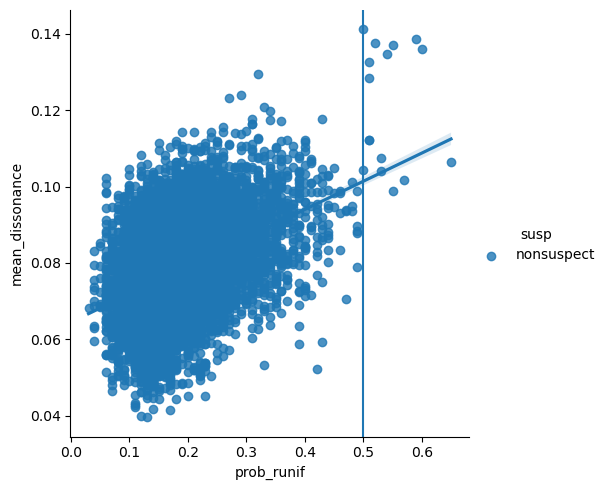

In [34]:
nonsuspects = mdfsavg[~mdfsavg.index.isin(suspects.index)]["ID      "]
mdfns = mdfs.query("`ID      `.isin(@nonsuspects)")

dfns = pd.concat(
    [
        mdfns.iloc[:, np.r_[0, -1]],
        mdfns.iloc[:, 1:-1].mean(axis=1).rename("mean_dissonance"),
    ],
    axis=1,
)

dfns = pd.concat(
    [
        mdfs.iloc[:, np.r_[0, -1]],
        mdfs.iloc[:, 1:-1].mean(axis=1).rename("mean_dissonance"),
    ],
    axis=1,
)

dfns["susp"] = np.where(dfns.index.isin(suspects.index), "suspect", "nonsuspect")

sns.lmplot(dfns, x="prob_runif", y="mean_dissonance", hue="susp", lowess=False)

plt.axvline(x=0.5)

In [27]:
groups = ["qsampled", "actual"]

questions_asked = 200
_diss_dataset(diss[9], questions_asked, groups=groups)

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.206377,0.000000,0.000000,0.000000,0.000000,0.528981,0.0,0.000000,0.903226,qsampled
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.810916,0.000000,0.000000,0.24918,0.000000,...,0.395648,0.000000,0.235294,0.371053,0.496386,0.000000,0.5,0.000000,0.903226,qsampled
2,0.111111,0.000000,0.000000,0.844261,0.670052,0.000000,0.000000,0.687277,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.913600,0.933560,0.044034,0.0,0.490939,0.000000,qsampled
3,0.000000,0.000000,0.786330,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.116518,0.369412,0.300926,0.858824,0.269439,0.848951,1.0,0.000000,0.000000,qsampled
4,0.000000,0.519520,0.000000,0.000000,0.000000,0.000000,0.846263,0.645823,0.00000,0.738565,...,0.087968,0.000000,0.000000,0.270686,0.505086,0.000000,1.0,0.736889,0.903226,qsampled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,0.000000,0.000000,0.740053,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.127481,0.967229,0.000000,0.000000,0.000000,0.854750,0.0,0.000000,0.000000,actual
1232,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.018237,0.386550,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,actual
1233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.486676,0.00000,0.000000,...,0.665909,0.000000,0.000000,0.000000,0.000000,0.543525,0.0,0.000000,0.000000,actual
1234,0.000000,0.706564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.550962,0.0,0.777778,0.000000,actual


## Expert malingering case

In [35]:
groups = ["qsampled", "m2"]
questions_asked = 200
alpha = 0.01

mdfs = pd.concat(
    [
        _maling_prob(
            d,
            groups,
            questions_asked,
            pd.read_csv("data/gibbonsglobal.csv")["ID      "],
        )
        for d in diss
    ]
)
mdfsavg = mdfs.groupby("ID      ", as_index=False).mean()

suspects = pd.concat(
    [
        pd.read_csv(
            f"disson_global/core/disson_global_core_with_actual_random_order_suspects_{i}__{alpha}.csv",
            index_col=0,
        )
        for i in range(8)
    ]
)
suspects_mean = suspects.groupby(suspects.index).mean()

# suspects_prob = mdfsavg.iloc[suspects.index, [0, -1]].join(suspects)
# display(suspects_prob)

print(f"mean {groups[1]} prob: ", mdfsavg[f"prob_{groups[1]}"].mean())
# print(f"mean {groups[1]} prob (suspects): ", mdfsavg.iloc[suspects.index, -1].mean())

# susp_diss = pd.concat(
#    [
#        _maling_prob(diss[i], groups, questions_asked)
#        .join(
#            pd.read_csv(
#                f"disson_global/core/disson_global_core_with_actual_random_order_suspects_{i}__{alpha}.csv",
#                index_col=0,
#            )
#        )
#        .assign(alpha=alpha)
#        for i in range(len(diss))
#        for alpha in [0.01]
#    ]
# )

# sns.lmplot(susp_diss, x="prob_runif", y="mean_dissonance", lowess=True)

mean m2 prob:  0.3338891585760518


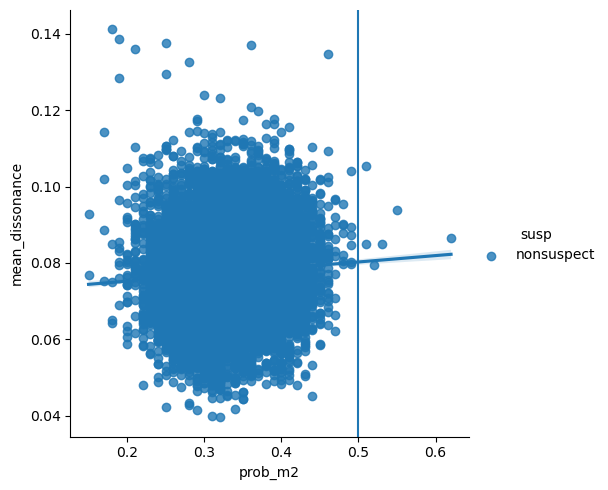

In [36]:
nonsuspects = mdfsavg[~mdfsavg.index.isin(suspects.index)]["ID      "]
mdfns = mdfs.query("`ID      `.isin(@nonsuspects)")

dfns = pd.concat(
    [
        mdfns.iloc[:, np.r_[0, -1]],
        mdfns.iloc[:, 1:-1].mean(axis=1).rename("mean_dissonance"),
    ],
    axis=1,
)

dfns = pd.concat(
    [
        mdfs.iloc[:, np.r_[0, -1]],
        mdfs.iloc[:, 1:-1].mean(axis=1).rename("mean_dissonance"),
    ],
    axis=1,
)

dfns["susp"] = np.where(dfns.index.isin(suspects.index), "suspect", "nonsuspect")

sns.lmplot(dfns, x="prob_m2", y="mean_dissonance", hue="susp", lowess=False)

plt.axvline(x=0.5)

# Debugging

In [37]:
d = pd.read_pickle(
    "disson_global/core/disson_global_core_with_actual_random_order_disson_0.pkl"
)

s = pd.read_pickle(
    "disson_global/core/disson_global_core_with_actual_random_order_samples_0.pkl"
)

In [57]:
s.keys()

dict_keys(['actual', 'qsampled', 'm2', 'runif'])

In [62]:
len(s["m2"][99])

222

In [64]:
for i in range(10):
    s = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_random_order_samples_{i}.pkl"
    )
    print(np.unique([s["actual"][i].shape for i in range(1236)]))

[222]
[222]
[227]
[235]
[227]
[239]
[239]
[222]
[235]
[235]


In [63]:
for i in range(10):
    s = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_random_order_samples_{i}.pkl"
    )
    print(np.unique([s["qsampled"][i].shape for i in range(100)]))

[222]
[222]
[227]
[235]
[227]
[239]
[239]
[222]
[235]
[235]


In [65]:
for i in range(10):
    s = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_random_order_samples_{i}.pkl"
    )
    print(np.unique([s["m2"][i].shape for i in range(100)]))

[222]
[222]
[227]
[235]
[227]
[239]
[239]
[222]
[235]
[235]


In [66]:
for i in range(10):
    s = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_random_order_samples_{i}.pkl"
    )
    print(np.unique([s["runif"][i].shape for i in range(100)]))

[222]
[222]
[227]
[235]
[227]
[239]
[239]
[222]
[235]
[235]


In [69]:
for i in range(10):
    s = pd.read_pickle(
        f"disson_global/core/disson_global_core_random_order_samples_{i}.pkl"
    )
    print(np.unique([s["qsampled"][i].shape for i in range(100)]))

[234]
[234]
[235]
[239]
[235]
[239]
[239]
[239]
[234]
[239]


In [70]:
for i in range(10):
    s = pd.read_pickle(
        f"disson_global/core/disson_global_core_random_order_samples_{i}.pkl"
    )
    print(np.unique([s["m2"][i].shape for i in range(100)]))

[234]
[234]
[235]
[239]
[235]
[239]
[239]
[239]
[234]
[239]


In [68]:
pd.read_csv("data/global.csv").iloc[0, :].isna().sum()

366

In [71]:
pd.read_csv("tmpfile.csv")

,2,3,5,6,7,8,9,10,11,12,...,4592,4593,4594,4596,4631,4632,4634,4635,4636,4637
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
1232,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
1233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN
